In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from datetime import datetime
import ipfx

import os
import pg8000

from ipfx.dataset.create import create_ephys_data_set

from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps

import seaborn as sns
from ipfx.epochs import get_stim_epoch

from ipfx.feature_extractor import (
    SpikeFeatureExtractor, SpikeTrainFeatureExtractor
)
from ipfx.stimulus_protocol_analysis import RampAnalysis


In [136]:
densities_path = "../data/channel_data_densities.xlsx"
df_densities = pd.read_excel(densities_path, sheet_name = 'peak_current_densities')

In [137]:
print(f"Number of cells with channel rec: {df_densities.shape[0]}")

Number of cells with channel rec: 1425


In [138]:
# Counts by species

# Human (sorting with Regex)
pattern_H = r'^H[0-9]\d'
df_pattern_H = df_densities.copy()
df_reg_H = df_pattern_H[df_pattern_H['cell'].str.contains(pattern_H, regex=True)]
df_H= df_reg_H.reset_index(drop=True)

# NHP (sorting with Regex)
pattern_QN = r'^QN[0-9]\d'
df_pattern_QN = df_densities.copy()
df_reg_QN = df_pattern_QN[df_pattern_QN['cell'].str.contains(pattern_QN, regex=True)]
df_QN= df_reg_QN.reset_index(drop=True)

#Mouse
pattern_m = r'^(H[0-9]\d|QN[0-9]\d)' #exclude all human and NHP
df_m = df_densities[~df_densities['cell'].str.contains(pattern_m, regex=True)].reset_index(drop=True)

C:\Users\maria.vergara\AppData\Local\Temp\ipykernel_29940\899006742.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_m = df_densities[~df_densities['cell'].str.contains(pattern_m, regex=True)].reset_index(drop=True)


In [139]:
df_m.head(3)

,cell,tot_-50,tot_-35,tot_-20,tot_-5,tot_10,tot_25,tot_40,tot_55,tot_70,...,nonfast_50,nonfast_-120,nonfast_-105,nonfast_-90,nonfast_-75,nonfast_-60,nonfast_-45,nonfast_-30,nonfast_-15,nonfast_0
0,Ctgf-T2A-dgCre;Ai14-496566.03.01.01,0.074444,0.267532,0.695577,1.305129,2.002863,2.399162,2.781400,3.511871,3.651309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rbp4-Cre_KL100;Ai14-658999.10.09.02,0.069235,0.407896,0.874963,2.587283,5.070571,7.246029,8.901930,10.373590,11.242473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ctgf-T2A-dgCre;Ai14-509689.04.02.01,0.184972,0.169915,0.382888,NaN,1.385268,1.760363,2.174393,2.209563,2.581076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# Counts per species
df_m.shape[0] + df_H.shape[0] + df_QN.shape[0] == df_densities.shape[0]
df_m.shape[0], df_H.shape[0], df_QN.shape[0]

(1010, 312, 103)

## Merge with ttype datasets per species

In [178]:
try:
    # Human - Use tree_subclass	and tree_cluster for ttype
    h_ttypes_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/human/human_patchseq_MTG_current/mapping.df.lastmap.csv'
    df_human_ttypes = pd.read_csv(h_ttypes_path) 
    df_human_ttypes_reduced = df_human_ttypes[['cell_name_label', 'tree_subclass', 'tree_cluster', 'tree_class']]

    df_human_ch_tt = pd.merge(left = df_H, left_on = 'cell',
                right = df_human_ttypes_reduced, right_on = 'cell_name_label', how = 'inner')


    # Merge with ephys data (query from LIMS)
    df_hum_ephys = pd.read_csv('../data/results_human_query.csv')
    df_human_ch_tt_ephys = pd.merge(left = df_human_ch_tt, left_on = 'cell',
                                    right = df_hum_ephys, right_on = 'name', how = 'inner')
    
    # Merge with homology dictionary
    df_dict_hom = pd.read_excel('../data/hodge_MvH_homology_mapping.xlsx')
    df_human = pd.merge(left = df_human_ch_tt_ephys, left_on = 'tree_cluster',
                        right = df_dict_hom, right_on = 'cluster_name', how = 'inner')

    # Mouse 
    m_ttypes_path = '//allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse/mouse_patchseq_WB_current/mapping.df.lastmap.csv'
    df_mouse_ttypes = pd.read_csv(m_ttypes_path)
    df_mouse_ch_tt = pd.merge(left = df_m, left_on = 'cell',
                              right = df_mouse_ttypes, right_on='cell_name', how='inner')

    # Merge with ephys data (query from LIMS)
    df_mouse_ephys = pd.read_csv('../data/results_mouse_query.csv')
    df_mouse = pd.merge(left = df_mouse_ch_tt, left_on = 'cell',
                        right = df_mouse_ephys, right_on = 'name', how = 'inner')
    # New col for class
    df_mouse['class'] = df_mouse['best.class_label'].apply(
        lambda x: 'Glutamatergic' if 'Glut' in x else ('GABAergic' if 'GABA' in x else 'Unknown'))

    # Create excel file from dataframes - for remote use.
    df_mouse.to_excel(f'../data/mouse_tt_ch_ephys.xlsx', index=False)
    df_human.to_excel(f'../data/human_tt_ch_ephys.xlsx', index=False)
    print('Data loaded and saved to local files.')
    
    df_human_ch_tt.to_excel(f'../data/human_tt_ch_for_IPFX.xlsx', index=False)
    df_mouse_ch_tt.to_excel(f'../data/mouse_tt_ch_for_IPFX.xlsx', index=False)
    
except:
    print('Data directory not available. Loading from local files.')
    df_mouse = pd.read_excel('../data/mouse_tt_ch_ephys.xlsx')
    df_human = pd.read_excel('../data/human_tt_ch_ephys.xlsx')

C:\Users\maria.vergara\AppData\Local\Temp\ipykernel_29940\47084026.py:4: DtypeWarning: Columns (104,107,110,137,548,556,561,562,563,564,572,655,666) have mixed types. Specify dtype option on import or set low_memory=False.
  df_human_ttypes = pd.read_csv(h_ttypes_path)
C:\Users\maria.vergara\AppData\Local\Temp\ipykernel_29940\47084026.py:23: DtypeWarning: Columns (21,28,33,34,35,36,94,112,122,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mouse_ttypes = pd.read_csv(m_ttypes_path)


Data loaded and saved to local files.


In [184]:
df_human['homol_cluster'], df_human['tree_cluster']

(0            Sst 4
 1            Sst 1
 2            Sst 1
 3            Sst 1
 4            Sst 1
           ...     
 190        Exc L6b
 191    Exc L6 IT 2
 192          Sst 3
 193          Sst 3
 194          Vip 3
 Name: homol_cluster, Length: 195, dtype: object,
 0        Inh L4-5 SST STK32A
 1        Inh L4-6 SST B3GAT2
 2        Inh L4-6 SST B3GAT2
 3        Inh L4-6 SST B3GAT2
 4        Inh L4-6 SST B3GAT2
                ...          
 190      Exc L6 FEZF2 SCUBE1
 191    Exc L5-6 THEMIS FGF10
 192     Inh L5-6 SST NPM1P10
 193     Inh L5-6 SST NPM1P10
 194      Inh L1-2 VIP PCDH20
 Name: tree_cluster, Length: 195, dtype: object)

In [142]:
df_mouse['best.class_label'].unique()

array(['NP-CT-L6b Glut', 'HY Glut', 'MY Glut', 'IT-ET Glut',
       'CTX-MGE GABA', 'TH Glut', 'OB-IMN GABA', 'CNU GABA',
       'CTX-CGE GABA', 'MB GABA', 'MB-HB Sero', 'CNU-HYa GABA', 'HY GABA',
       'MB Dopa', 'P GABA', 'P Glut', 'MB Glut', 'CNU-HYa Glut',
       'LSX GABA', 'MH-LH Glut'], dtype=object)

## Number of cells in channel data densities file

Text(0.5, 1.0, 'Number of cells with channel rec, ttype and ephys')

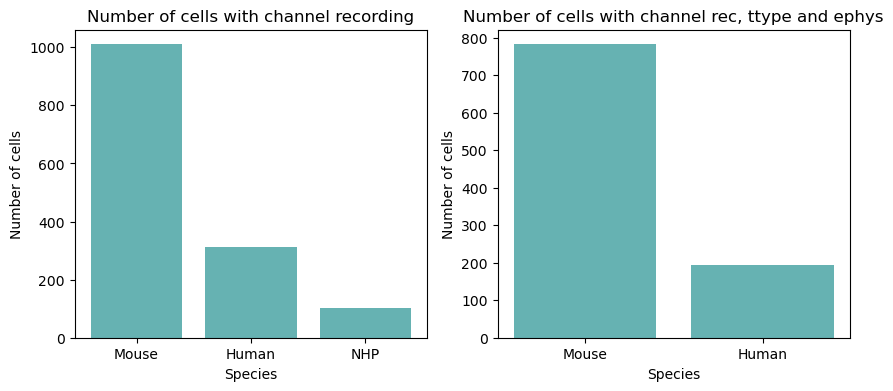

In [143]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].bar(['Mouse','Human','NHP'],[df_m.shape[0], df_H.shape[0], df_QN.shape[0]], color = 'teal', alpha=0.6)
ax[0].set_ylabel('Number of cells')
ax[0].set_xlabel('Species')
ax[0].set_title('Number of cells with channel recording')

ax[1].bar(['Mouse', 'Human'], [df_mouse.shape[0],df_human.shape[0]], color = 'teal', alpha=0.6)
ax[1].set_ylabel('Number of cells')
ax[1].set_xlabel('Species')
ax[1].set_title('Number of cells with channel rec, ttype and ephys')

Parameters mouse:
['cell', 'tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10', 'tot_25',
       'tot_40', 'tot_55', 'tot_70_x', 'tot_85', 'tot_-70', 'tot_-55',
       'tot_-40', 'tot_-25', 'tot_-10', 'tot_5', 'tot_20', 'tot_35', 'tot_50',
       'fast_-50', 'fast_-35', 'fast_-20', 'fast_-5', 'fast_10', 'fast_25',
       'fast_40', 'fast_55', 'fast_70_x', 'fast_85', 'fast_-70', 'fast_-55',
       'fast_-40', 'fast_-25', 'fast_-10', 'fast_5', 'fast_20', 'fast_35',
       'fast_50', 'slow_-50', 'slow_-35', 'slow_-20', 'slow_-5', 'slow_10',
       'slow_25', 'slow_40', 'slow_55', 'slow_70', 'slow_85', 'sus_-50',
       'sus_-35', 'sus_-20', 'sus_-5', 'sus_10', 'sus_25', 'sus_30', 'sus_40',
       'sus_55', 'sus_70', 'sus_85', 'sus_0', 'sus_15', 'sus_30.1', 'sus_45',
       'sus_60', 'sus_75', 'sus_90', 'sus_105', 'sus_120', 'nonfast_-50',
       'nonfast_-35', 'nonfast_-20', 'nonfast_-5', 'nonfast_10', 'nonfast_25',
       'nonfast_40', 'nonfast_55', 'nonfast_70_x', 'nonfast_85', 'nonfast_-70',
       'nonfast_-55', 'nonfast_-40', 'nonfast_-25', 'nonfast_-10', 'nonfast_5',
       'nonfast_20', 'nonfast_35', 'nonfast_50', 'nonfast_-120',
       'nonfast_-105', 'nonfast_-90', 'nonfast_-75', 'nonfast_-60',
       'nonfast_-45', 'nonfast_-30', 'nonfast_-15', 'nonfast_0', 'tot_70_y',
       'fast_70_y', 'fast_total', 'nonfast_70_y', 'nonfast_total', 'jem-date_patch', 'jem-id_species',
       'jem-id_patched_cell_container', 'jem-id_rig_user', 'jem-roi_super',
       'jem-roi_major', 'jem-roi_minor', 'cell_id',
       'rna_amplification_pass_fail', 'Genes.Detected.CPM', 'avg.cor', 'ttype',
       'supertype', 'subclass', 'ephys_qc', 'failed_bad_rs',
       'failed_electrode_0', 'tau', 'avg_isi',
       'upstroke_downstroke_ratio_short_square', 'threshold_v_ramp',
       'peak_v_short_square', 'upstroke_downstroke_ratio_ramp', 'sag',
       'trough_t_ramp', 'slow_trough_v_ramp', 'vrest', 'has_pause',
       'trough_v_long_square', 'input_resistance_mohm',
       'trough_t_short_square', 'fast_trough_v_ramp', 'trough_t_long_square',
       'threshold_v_long_square', 'slow_trough_v_long_square', 'peak_t_ramp',
       'threshold_t_short_square', 'slow_trough_t_long_square',
       'input_access_resistance_ratio', 'fast_trough_t_long_square', 'ri',
       'threshold_t_long_square', 'threshold_v_short_square',
       'threshold_t_ramp', 'vm_for_sag', 'threshold_i_long_square',
       'threshold_i_short_square', 'slow_trough_t_ramp', 'peak_v_ramp',
       'fast_trough_v_short_square', 'fast_trough_t_short_square',
       'fast_trough_t_ramp', 'initial_access_resistance_mohm',
       'slow_trough_t_short_square', 'threshold_i_ramp',
       'slow_trough_v_short_square', 'peak_t_short_square',
       'trough_v_short_square', 'f_i_curve_slope', 'created_at',
       'peak_t_long_square', 'seal_gohm', 'trough_v_ramp', 'latency',
       'fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square',
       'Unnamed: 72', 'peak_v_long_square', 'adaptation'],

Parameters human:
['cell', 'tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10', 'tot_25',
       'tot_40', 'tot_55', 'tot_70', 'tot_85', 'tot_-70', 'tot_-55', 'tot_-40',
       'tot_-25', 'tot_-10', 'tot_5', 'tot_20', 'tot_35', 'tot_50', 'fast_-50',
       'fast_-35', 'fast_-20', 'fast_-5', 'fast_10', 'fast_25', 'fast_40',
       'fast_55', 'fast_70', 'fast_85', 'fast_-70', 'fast_-55', 'fast_-40',
       'fast_-25', 'fast_-10', 'fast_5', 'fast_20', 'fast_35', 'fast_50',
       'slow_-50', 'slow_-35', 'slow_-20', 'slow_-5', 'slow_10', 'slow_25',
       'slow_40', 'slow_55', 'slow_70', 'slow_85', 'sus_-50', 'sus_-35',
       'sus_-20', 'sus_-5', 'sus_10', 'sus_25', 'sus_30', 'sus_40', 'sus_55',
       'sus_70', 'sus_85', 'sus_0', 'sus_15', 'sus_30.1', 'sus_45', 'sus_60',
       'sus_75', 'sus_90', 'sus_105', 'sus_120', 'nonfast_-50', 'nonfast_-35',
       'nonfast_-20', 'nonfast_-5', 'nonfast_10', 'nonfast_25', 'nonfast_40',
       'nonfast_55', 'nonfast_70', 'nonfast_85', 'nonfast_-70', 'nonfast_-55',
       'nonfast_-40', 'nonfast_-25', 'nonfast_-10', 'nonfast_5', 'nonfast_20',
       'nonfast_35', 'nonfast_50', 'nonfast_-120', 'nonfast_-105',
       'nonfast_-90', 'nonfast_-75', 'nonfast_-60', 'nonfast_-45',
       'nonfast_-30', 'nonfast_-15', 'nonfast_0', 'seq-name', 'cell_id',
       'patched_cell_container_label', 'cell_name_label', 'batch_vendor_name_label',
       'SEAAD_class_label.assignment',
       'SEAAD_class_label.bootstrapping_probability',
       'SEAAD_class_label.avg_correlation', 'SEAAD_subclass_label.assignment',
       'SEAAD_subclass_label.bootstrapping_probability',
       'SEAAD_subclass_label.avg_correlation',
       'SEAAD_cluster_label.assignment',
       'SEAAD_cluster_label.bootstrapping_probability',
       'SEAAD_cluster_label.avg_correlation', 'SEAAD_score.Corr',
       'SEAAD_cluster_Corr', 'SEAAD_subclass_Corr', 'SEAAD_class_Corr',
       'rna_amplification_pass_fail', 'library_prep_pass_fail',
       'percent_reads_aligned_to_exons', 'percent_reads_aligned_to_mt_exons',
       'percent_reads_aligned_to_introns',
       'percent_reads_aligned_to_intergenic', 'percent_reads_aligned_unique',
       'percent_reads_aligned_to_ecoli',
       'percent_reads_aligned_to_synthetic_constructs',
       'percent_reads_aligned_total', 'complexity_aatt', 'complexity_acgt',
       'complexity_agct', 'complexity_at', 'complexity_catg',
       'complexity_ccgg', 'complexity_cg', 'complexity_gatc', 'complexity_gc',
       'complexity_ta', 'fpkm_published', 'fpkm_dir', 'fpkm_filename',
       'Genes.Detected', 'Exclude.STAR', 'TreeMatch_1', 'TreeProb_1',
       'TreeMatch_2', 'TreeProb_2', 'TreeMatch_3', 'TreeProb_3', 'score.Corr',
       'score.Tree', 'cluster_Corr', 'subclass_Corr', 'class_Corr', 'cluster_Tree', 'subclass_Tree', 'class_Tree', 'cluster',
       'cluster_score', 'res.index', 'quality_score', 'marker_sum_norm',
       'Norm_Marker_Sum.0.4', 'contaminationType', 'contam_sum', 'Tree_call',
       'Tree_first_cor', 'Tree_first_bt', 'Tree_second_bt', 'Tree_first_KL',
       'Tree_second_KL', 'seuratQCpass', 'UMAP_x', 'UMAP_y',
       'class_MapMyCells', 'class_MapMyCells_softmax_probability',
       'subclass_MapMyCells', 'subclass_MapMyCells_softmax_probability',
       'supertype_MapMyCells', 'supertype_MapMyCells_softmax_probability'

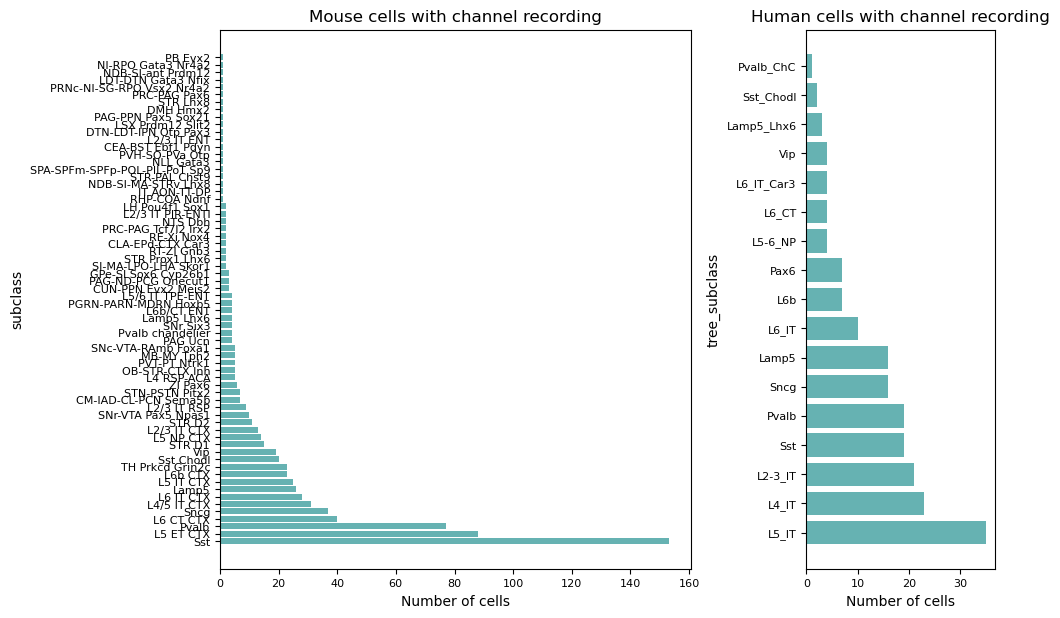

In [152]:
classification_m = 'subclass' # 'ttype','supertype', 'subclass'
classification_h = 'tree_subclass' # 'tree_cluster', 'tree_subclass', 'tree_class'

fig, ax = plt.subplots(1,2,figsize=(10,7), gridspec_kw={'wspace': 0.35},
                      width_ratios= [2,0.8] )
for i, species, classification, df_species in zip([0,1],['Mouse', 'Human'],
                                            [classification_m, classification_h],
                                            [df_mouse, df_human]):
    
    ax[i].barh(df_species[classification].value_counts().index,
               df_species[classification].value_counts(), color = 'teal',
               alpha=0.6)
    ax[i].tick_params(axis='both', labelsize=8)
    ax[i].set_xlabel('Number of cells')
    ax[i].set_ylabel(f'{classification}')
    ax[i].set_title(f'{species} cells with channel recording')

### Samples for the dashboard

#### Scatterplots of columns

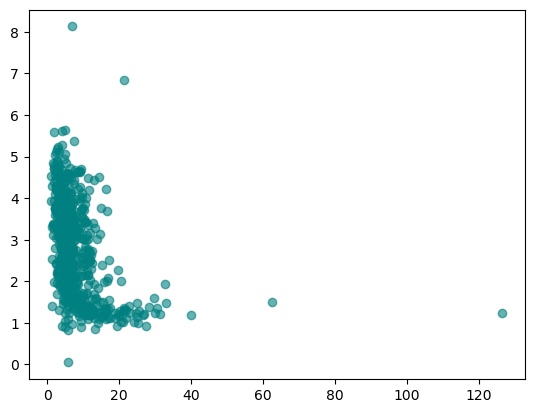

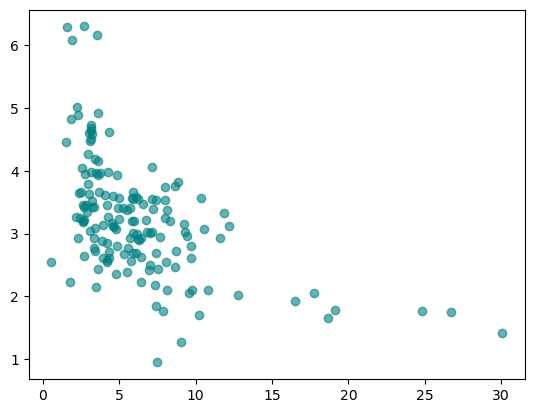

In [148]:
plt.scatter(df_mouse['tot_70'], df_mouse['upstroke_downstroke_ratio_ramp'], color = 'teal', alpha=0.6)
plt.show()
plt.scatter(df_human['tot_70'], df_human['upstroke_downstroke_ratio_ramp'], color = 'teal', alpha=0.6)

## Homology analysis

### Total, slow and fast 70 currents by homology cluster.
For Human only for now, bc haven't joined homol dict for mouse, the one I have is based on visual cortex, so Brian will send me the other dictionary for mouse (there is no column to join with mouse data).

In [123]:
print('Total 70: ', df_human['tot_70'][0])
print('Slow 70 + Fast 70: ', df_human['slow_70'][0] + df_human['fast_70'][0])
print('Nonfast 70 + Fast: ', df_human['nonfast_70'][0] + df_human['fast_70'][0])

Total 70:  9.776307502813875
Slow 70 + Fast 70:  10.244892139949314
Nonfast 70 + Fast:  10.287791876062425


### UMAP with the main features

In [124]:
import umap
df_human['avg_isi']

# Select specific feature columns
feature_cols = ['tot_70','upstroke_downstroke_ratio_ramp', 'avg_isi', 'latency', 'tau', 'ri']
H = df_human[feature_cols].dropna()  # Extract only the desired features

In [125]:
umap_model = umap.UMAP(
    n_neighbors=16, 
    n_components=2,  
    random_state=42
)
embedding = umap_model.fit_transform(H)  # Fit and transform the data

df_umap = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])


c:\Users\maria.vergara\AppData\Local\anaconda3\envs\IVSCC\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


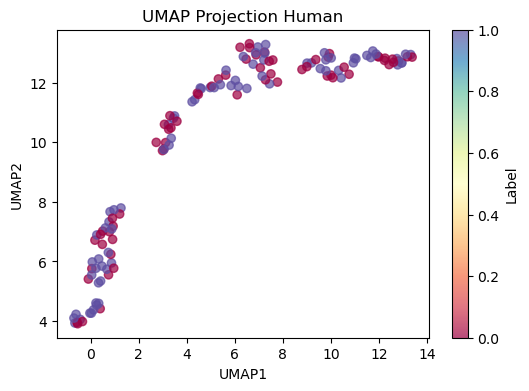

In [126]:
df_human_filtered = df_human.loc[df_umap.index]

labels_numeric_H = pd.factorize(df_human_filtered['tree_class'])[0]


plt.figure(figsize=(6, 4))
plt.scatter(
    df_umap['UMAP1'], 
    df_umap['UMAP2'], 
    c=labels_numeric_H,  
    cmap='Spectral', 
    alpha=0.7
)
plt.colorbar(label="Label")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP Projection Human")
plt.show()